In [6]:
import torch
import torchvision.models as models

In [7]:
from torchvision import datasets, models, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
import os

data_dir = 'data/hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=5,
        shuffle=True, num_workers=4
    )
    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# Visualization 

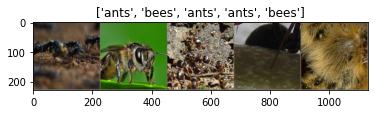

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [10]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions


In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the model

In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft,
    exp_lr_scheduler,num_epochs = 25
)

Epoch 0/24
----------
train Loss: 0.5380 Acc: 0.7172
val Loss: 0.1857 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5301 Acc: 0.7623
val Loss: 0.2138 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4724 Acc: 0.8115
val Loss: 0.3371 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.3340 Acc: 0.8770
val Loss: 0.2276 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4145 Acc: 0.8361
val Loss: 0.2551 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3945 Acc: 0.8443
val Loss: 0.3198 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.2823 Acc: 0.8770
val Loss: 0.2568 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2058 Acc: 0.9344
val Loss: 0.2389 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2973 Acc: 0.8893
val Loss: 0.2429 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2061 Acc: 0.9139
val Loss: 0.2233 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2210 Acc: 0.8975
val Loss: 0.2272 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2477 Acc: 0.8934
val Loss: 0.2267 Acc: 0.9346

Ep

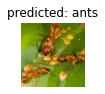

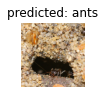

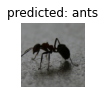

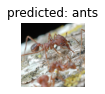

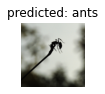

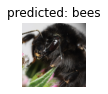

In [14]:
visualize_model(model_ft)

# ResNet as Feature extractor
Freeze all the network except the final layer.

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze the network
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(
    model_conv, criterion, optimizer_conv,
    exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5685 Acc: 0.7008
val Loss: 0.2389 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4820 Acc: 0.7705
val Loss: 0.1997 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4304 Acc: 0.8279
val Loss: 0.2156 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5934 Acc: 0.7213
val Loss: 0.2514 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3563 Acc: 0.8443
val Loss: 0.2207 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3258 Acc: 0.8730
val Loss: 0.1811 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3716 Acc: 0.8443
val Loss: 0.2079 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3404 Acc: 0.8484
val Loss: 0.1955 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3229 Acc: 0.8443
val Loss: 0.2037 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3091 Acc: 0.8689
val Loss: 0.2049 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2937 Acc: 0.8770
val Loss: 0.1934 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3047 Acc: 0.8566
val Loss: 0.2078 Acc: 0.9281

Ep

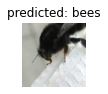

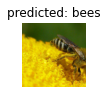

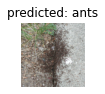

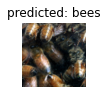

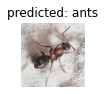

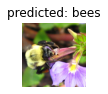

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()